In [1]:
import zipfile 
import pysal as ps
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
import gzip
import mapreduce as mr
import csv

In [2]:
fname = 'Data/CensusTracks.geojson'
tracks = gpd.GeoDataFrame.from_file(fname)
tracks.head()

,Within15min,Within30min,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng
0,0,0,5,5000900,Staten Island,I,000900,9,(POLYGON ((-74.07920577013245 40.6434307837456...,0,SI22,West New Brighton-New Brighton-St. George,3903,2497009.69813,7729.01679376
1,0,0,5,5007400,Staten Island,I,007400,74,(POLYGON ((-74.05974734759452 40.5938486115672...,1,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5788237.79601,9902.94847281
2,0,0,1,1009800,Manhattan,I,009800,98,(POLYGON ((-73.96432543478758 40.7563815309909...,2,MN19,Turtle Bay-East Midtown,3808,1906016.35002,5534.19981063
3,0,0,1,1010000,Manhattan,I,010000,100,(POLYGON ((-73.96802436915851 40.7595781400528...,3,MN19,Turtle Bay-East Midtown,3808,1860938.37721,5692.16873705
4,0,0,1,1010200,Manhattan,I,010200,102,(POLYGON ((-73.97124277307127 40.7609364184790...,4,MN17,Midtown-Midtown South,3807,1860992.70485,5687.80243866


In [33]:
validCT = set(tracks[tracks.Within30min == True].boro_ct_2010)

In [35]:
def maptracks(row):
    if row['h_track'] in validCT:
        if row['h_track'][0]=='3':
            #print 'yes'
            if row['w_track'][0]=='1':
                #print 'yes'
                yield (row['w_track'], row['h_track'],int(row['S000']))

def reducehtracks(counts, pair):
    counts[pair[1]] = counts.get(pair[1], 0)+pair[2]
    return counts

with open('Data/True_nyod_JT00thegood_2014.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    output2 = sorted(reduce(reducehtracks,list(mr.run(reader,maptracks)), {}).items())
print len(output2)
output2[:10]

239
1


[('3000100', 1405),
 ('3002100', 1873),
 ('3019100', 736),
 ('3024100', 681),
 ('3025300', 695),
 ('3025500', 713),
 ('3025700', 466),
 ('3025901', 417),
 ('3025902', 482),
 ('3026100', 1059)]

In [41]:
tracks['HomeAffected'] = 0
tracks['JobsAffected'] = 0
def affectedHome(track_Count):
    tracks.loc[tracks.boro_ct_2010 == track_Count[0],'HomeAffected'] = track_Count[1]
    return
map(affectedHome,output2)
print 'done'

done


In [42]:
tracks[tracks.HomeAffected>0].head()

,Within15min,Within30min,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng,HomeAffected,JobsAffected
100,0,1,3,3026300,Brooklyn,E,026300,263,(POLYGON ((-73.9420768492443 40.68869720248089...,100,BK75,Bedford,4003,1287405.97132,4799.55684944,338,0
112,0,1,3,3027900,Brooklyn,E,027900,279,(POLYGON ((-73.93617169991664 40.6886267476856...,112,BK35,Stuyvesant Heights,4003,1743087.9778,5389.74582137,608,0
114,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824,170,0
116,0,1,3,3029100,Brooklyn,E,029100,291,(POLYGON ((-73.93032510585428 40.6892972646220...,116,BK35,Stuyvesant Heights,4003,1772059.65213,5439.93915313,552,0
117,0,1,3,3029300,Brooklyn,E,029300,293,(POLYGON ((-73.93017996947596 40.6885651406574...,117,BK35,Stuyvesant Heights,4003,1770060.57626,5437.78521721,571,0


In [45]:
homeaffected = tracks[tracks.HomeAffected>0].HomeAffected
homeaffected = ps.Quantiles(homeaffected, k=6)
homeaffected

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=  337.667               40
 337.667 < x[i] <=  428.667               40
 428.667 < x[i] <=  555.000               40
 555.000 < x[i] <=  668.333               39
 668.333 < x[i] <=  888.667               40
 888.667 < x[i] <= 1891.000               40

#### cmap spectral is great!

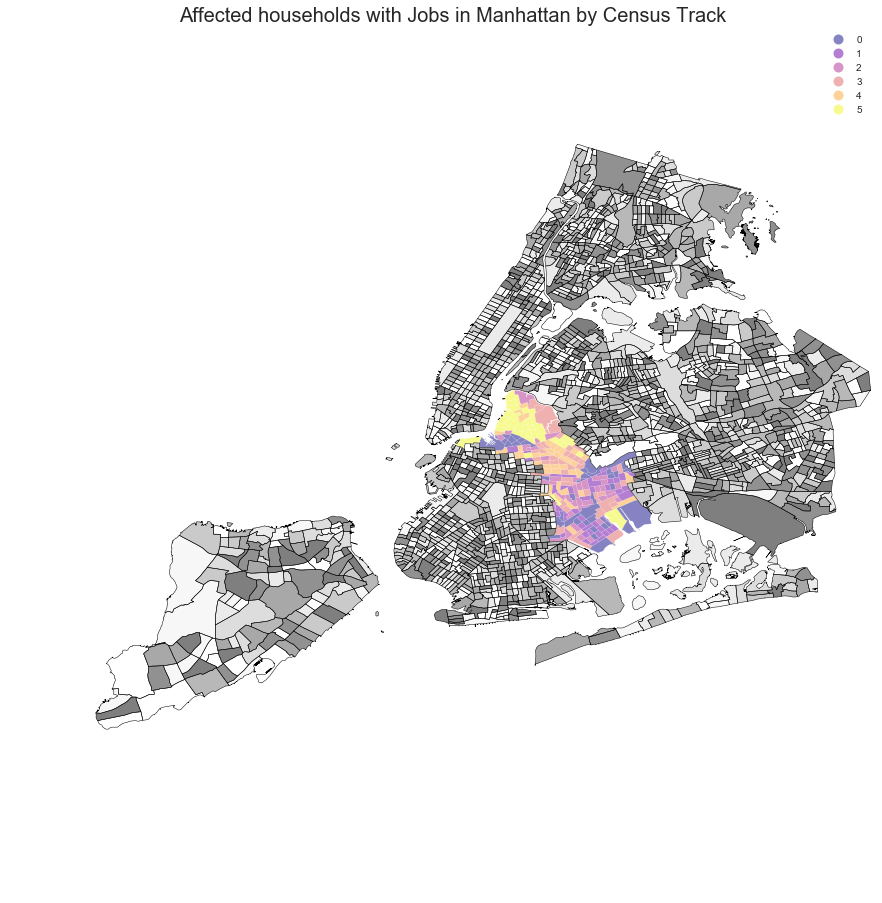

In [48]:
f, ax = pl.subplots(figsize=(15,15))

tracks[tracks.HomeAffected==0].plot(c = 'k', linewidth = .5, ax = ax)
tracks[tracks.HomeAffected>0].assign(cl = homeaffected.yb).plot(column = 'cl', categorical = True, k = 10, linewidth = .1,
                                          ax=ax, cmap='plasma', edgecolor='white', legend=True)

#for i in range(len(facilAsthma)):
#    pl.scatter((getXY(facilAsthma.geometry[i]))[0], (getXY(facilAsthma.geometry[i]))[1], 
#               s = 100, color = 'b', label = 'Facilities')
#pl.xlabel('longitude')
#pl.ylabel('latitude')
pl.axis('off')
#pl.legend()
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Affected households with Jobs in Manhattan by Census Track", size=20)

In [49]:
def maptracks(row):
    if row['h_track'] in validCT:
        if row['h_track'][0]=='3':
            #print 'yes'
            if row['w_track'][0]=='1':
                #print 'yes'
                yield (row['w_track'], row['h_track'],int(row['S000']))

def reducehtracks(counts, pair):
    counts[pair[0]] = counts.get(pair[0], 0)+pair[2]
    return counts

with open('Data/True_nyod_JT00thegood_2014.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    output2 = sorted(reduce(reducehtracks,list(mr.run(reader,maptracks)), {}).items())
print len(output2)
output2[:10]

285


[('1000100', 20),
 ('1000201', 33),
 ('1000202', 72),
 ('1000500', 5),
 ('1000600', 224),
 ('1000700', 3112),
 ('1000800', 102),
 ('1000900', 3631),
 ('1001001', 8),
 ('1001002', 33)]

In [55]:
def affectedJobs(track_Count):
    tracks.loc[tracks.boro_ct_2010 == track_Count[0],'JobsAffected'] = track_Count[1]
    return
map(affectedJobs,output2)
print 'done'

done


In [56]:
tracks[tracks.JobsAffected>0].head()

,Within15min,Within30min,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng,HomeAffected,JobsAffected
2,0,0,1,1009800,Manhattan,I,009800,98,(POLYGON ((-73.96432543478758 40.7563815309909...,2,MN19,Turtle Bay-East Midtown,3808,1906016.35002,5534.19981063,551,551
3,0,0,1,1010000,Manhattan,I,010000,100,(POLYGON ((-73.96802436915851 40.7595781400528...,3,MN19,Turtle Bay-East Midtown,3808,1860938.37721,5692.16873705,1570,1570
4,0,0,1,1010200,Manhattan,I,010200,102,(POLYGON ((-73.97124277307127 40.7609364184790...,4,MN17,Midtown-Midtown South,3807,1860992.70485,5687.80243866,1855,1855
5,0,0,1,1010400,Manhattan,I,010400,104,(POLYGON ((-73.97445730550224 40.7622930835248...,5,MN17,Midtown-Midtown South,3807,1864600.41684,5693.03636727,1958,1958
6,0,1,1,1011300,Manhattan,I,011300,113,(POLYGON ((-73.98411754823195 40.7548420534646...,6,MN17,Midtown-Midtown South,3807,1890907.29102,5699.8606412,2970,2970


In [59]:
jobsaffected = tracks[tracks.JobsAffected>0].JobsAffected
jobsaffected = ps.Quantiles(jobsaffected, k=6)
jobsaffected

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=   20.333               48
  20.333 < x[i] <=   60.000               49
  60.000 < x[i] <=  129.000               46
 129.000 < x[i] <=  296.667               47
 296.667 < x[i] <=  945.333               47
 945.333 < x[i] <= 5215.000               48

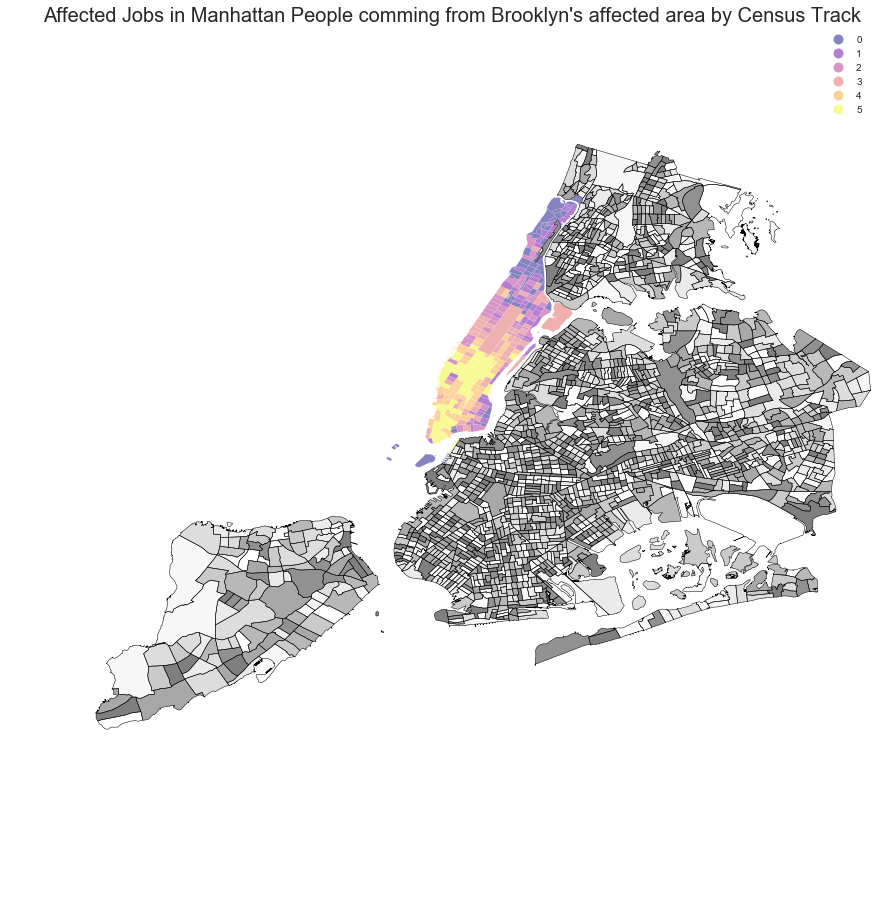

In [61]:
f, ax = pl.subplots(figsize=(15,15))

tracks[tracks.JobsAffected==0].plot(c = 'k', linewidth = .5, ax = ax)
tracks[tracks.JobsAffected>0].assign(cl = jobsaffected.yb).plot(column = 'cl', categorical = True, k = 10, linewidth = .1,
                                          ax=ax, cmap='plasma', edgecolor='white', legend=True)

#for i in range(len(facilAsthma)):
#    pl.scatter((getXY(facilAsthma.geometry[i]))[0], (getXY(facilAsthma.geometry[i]))[1], 
#               s = 100, color = 'b', label = 'Facilities')
#pl.xlabel('longitude')
#pl.ylabel('latitude')
pl.axis('off')
#pl.legend()
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Affected Jobs in Manhattan People comming from Brooklyn's affected area by Census Track", size=20)